# NBA Sleepers

## By: Carlos Villagomez & Kevin Tran

## CPSC 310, Spring 2019

## Introduction

We are using a dataset consisting of two decades worth of NBA player data ranging from the 1996-2016 seasons on each player's seasonal statistics who was a member of a team's roster. We implemented several classification models including K-Nearest Neighbor (KNN), Sklearn KNN, Naive Bayes, Sklearn Naive Bayes, Linear Regression, and Sklearn Linear Regression to classify whether a player is a "sleeper" or not. We define a "sleeper" pick as a player whose net rating, which is a stat that evaluates a team's point differential per 100 possessions while he is on the court is greater than or equal to the average player of the next highest draft stock. For example, someone like Zach Randolph, who is predicted to be selected in the Top 5, but was actually selected in the late 1st round would be classified as a "sleeper". We found that the most accurate classification approach was KNN when predicting the "sleeper" picks.

## Data Analysis

The dataset consists of 21 attribute values including each player's demographic variables (e.g. height, weight, age, etc.), biographical details (team, draft year, round, etc.), and basic box score statistics (avg points, rebounds, assists, etc.). There are 9,561 total instances of players, but only 1,892 unique players in the dataset. Now, there were initially 51 rows of missing data, but the author of the dataset handled this by manually filling the gaps using player data from the online database, Basketball Reference.

The data of the players were organized by averaging all their career stats and running a sleeper definer algorithm on them. The first figure shows the average net rating difference between the draft stocks, and that was used help to determine what is a proper "sleeper". The second figure shows the frequency of players in the laegue and where they were drafted. The number 0 indicates the players who played that were undrafted. The majority of the league is undrafted players. The third figure shows the differencee between a use percentage of a player and their net rank. There is correlation between a high net rating and high usage percentage; however, most players in the league are just average.

########################
Stat Summary of the Data
########################
Total Unqiue Players Analyzed:  1892
Average  gp :  268.20084566596194
Average  pts :  5.901963407943847
Average  ast :  1.3103850361277742
Average  reb :  2.7334402285872867
Average  net_rating :  -4.777268267068417
Average  usg_pct :  0.18219910543015408
Average  ts_pct :  0.47887587898399353
Average  ast_pct :  0.12128922972331578


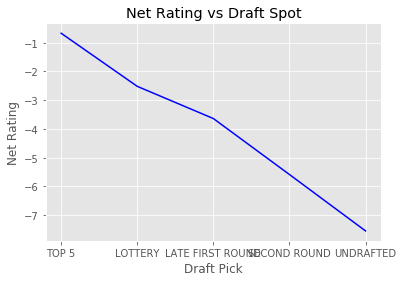

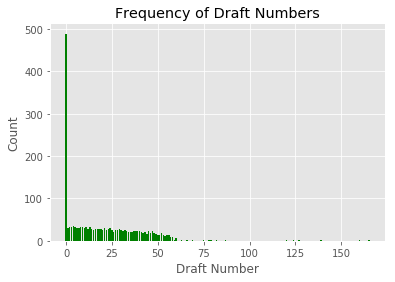

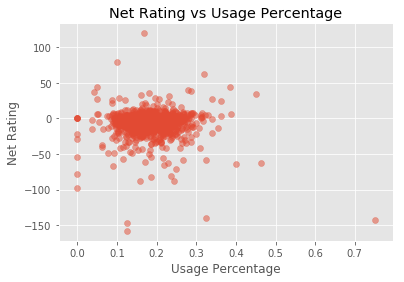

In [4]:
import csv
import matplotlib.pyplot as plot
import random
import numpy as np
import math
from collections import Counter
import operator
from csv import DictWriter, DictReader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report

matplotlib.style.use('ggplot') 

headers = ['player_name', 'college', 'draft_year', 'draft_round', 'draft_number',
           'gp', 'pts', 'reb', 'ast', 'net_rating', 'usg_pct', 'ts_pct', 'ast_pct']
linearRegressor = LinearRegression()


class Player:
    def __init__(self, data):
        self.player_name = data['player_name']
        self.college = data['college']
        self.draft_year = data['draft_year']
        self.draft_round = data['draft_round']
        self.draft_number = data['draft_number']
        self.gp = [float(data['gp'])]
        self.pts = [float(data['pts'])]
        self.reb = [float(data['reb'])]
        self.ast = [float(data['ast'])]
        self.net_rating = [float(data['net_rating'])]
        self.usg_pct = [float(data['usg_pct'])]
        self.ts_pct = [float(data['ts_pct'])]
        self.ast_pct = [float(data['ast_pct'])]
        self.sleeper = 0


def draft_converter(num):
    if num > 0 and num <= 5:
        return "TOP 5"
    elif num >= 6 and num <= 14:
        return "LOTTERY"
    elif num >= 15 and num <= 30:
        return "LATE FIRST ROUND"
    elif num >= 31:
        return "SECOND ROUND"
    else:
        return "UNDRAFTED"


def org_players(file, headers):
    with open(file) as read:
        csv_reader = csv.DictReader(read)
        players = {}
        for row in csv_reader:
            if row['player_name'] not in players:
                data = {}
                for i in headers:
                    data[i] = row[i]
                players[row['player_name']] = (Player(data))
            else:
                for i in headers[5:len(headers)]:
                    getattr(players[row['player_name']],
                            i).append(float(row[i]))

        for k, v in players.items():
            generate_career_avgs(v)
        return players


def generate_career_avgs(player):
    player.gp = sum(player.gp)
    player.pts = sum(player.pts) / len(player.pts)
    player.reb = sum(player.reb) / len(player.reb)
    player.ast = sum(player.ast) / len(player.ast)
    player.net_rating = sum(player.net_rating) / len(player.net_rating)
    player.usg_pct = sum(player.usg_pct) / len(player.usg_pct)
    player.ts_pct = sum(player.ts_pct) / len(player.ts_pct)
    player.ast_pct = sum(player.ast_pct) / len(player.ast_pct)
    if player.draft_number == "Undrafted":  # set all undrafted to 0
        player.draft_year = 0.0
        player.draft_round = 0.0
        player.draft_number = 0.0


def sort_to_table(players):
    table = []
    for k, v in players.items():
        table.append([v.player_name, v.gp, v.pts, v.reb,
                      v.ast, v.net_rating, v.usg_pct, v.ts_pct, v.ast_pct, int(v.draft_number), v.sleeper])
    return table

def sleeper_definer(players):
    avgs = {"TOP 5": [],  "LOTTERY": [],
            "LATE FIRST ROUND": [], "SECOND ROUND": [], "UNDRAFTED": []}

    for k, v in players.items():

        player_draft = draft_converter(int(v.draft_number))
        avgs[player_draft].append(v.net_rating)

    for k, v in avgs.items():
        avgs[k] = sum(v)/len(v)

    for k, v in players.items():
        player_draft = draft_converter(int(v.draft_number))

        if player_draft == "UNDRAFTED" and v.net_rating > avgs["LATE FIRST ROUND"]:
            players[k].sleeper = 1
        elif player_draft == "SECOND ROUND" and v.net_rating > avgs["LATE FIRST ROUND"]:
            players[k].sleeper = 1
        elif player_draft == "LATE FIRST ROUND" and v.net_rating > avgs["LOTTERY"]:
            players[k].sleeper = 1
        elif player_draft == "LOTTERY" and v.net_rating > avgs["TOP 5"]:
            players[k].sleeper = 1
def data_analysis(players, table):
    # ########################################################
    # Summary Statistics
    # ########################################################
    avg_data = {'gp': 0, 'pts': 0, 'ast':0, 'reb':0, 'net_rating': 0, 'usg_pct': 0, 'ts_pct': 0, 'ast_pct':0}

    for k, v in players.items():
        avg_data['gp'] += v.gp
        avg_data['pts'] += v.pts
        avg_data['ast'] += v.ast
        avg_data['reb'] += v.reb
        avg_data['net_rating'] += v.net_rating
        avg_data['usg_pct'] += v.usg_pct
        avg_data['ts_pct'] += v.ts_pct
        avg_data['ast_pct'] += v.ast_pct

    
    for key, value in avg_data.items():
        avg_data[key] = value/len(players)
    print("########################")
    print("Stat Summary of the Data")
    print("########################")
    print("Total Unqiue Players Analyzed: ", len(players))
    for key, value in avg_data.items():
        print("Average ", key,": ", value)
        
    # ########################################################
    # Net Rating vs Draft pick defining how we do our sleepers
    # ########################################################
    avgs = {"TOP 5": [],  "LOTTERY": [],
            "LATE FIRST ROUND": [], "SECOND ROUND": [], "UNDRAFTED": []}

    for k, v in players.items():

        player_draft = draft_converter(int(v.draft_number))
        avgs[player_draft].append(v.net_rating)

    for k, v in avgs.items():
        avgs[k] = sum(v)/len(v)
    
    y = [ v for k, v in avgs.items()]
    x = [ k for k, v in avgs.items()]

    plot.plot(x, y, color='blue')
    plot.title('Net Rating vs Draft Spot')
    plot.xlabel('Draft Pick')
    plot.ylabel('Net Rating')
    plot.show()



    # ########################################################
    # AMOUNT OF PEOPLE IN DRAFT AT THE NUMBER OF IT 
    # ########################################################
    freq = {}
    for p in table:
        if p[9] in freq:
            freq[p[9]] += 1
        else:
            freq[p[9]] = 1

    y = np.array([v for k,v in freq.items()])
    x = np.array([k for k,v in freq.items()])


    plt.bar(x, y, color='green')
    plt.xlabel("Draft Number")
    plt.ylabel("Count")
    plt.title("Frequency of Draft Numbers")
    plt.show()

    # ########################################################
    # Which value was more important in usuage vs net rating
    # ########################################################


    y = [p[6] for p in table]
    x = [p[5] for p in table]

    plt.scatter(y, x, alpha=0.5)
    plt.ylabel("Net Rating")
    plt.xlabel("Usage Percentage")
    plt.title("Net Rating vs Usage Percentage")
    plt.show()

players = org_players('all_seasons.csv', headers)
sleeper_definer(players)
table = sort_to_table(players)
data_analysis(players, table)


## Classification Results





## Conclusion

The dataset we used presented a few problems with analysis including  that the 51 rows that were initially missing data, but were handled by the author filled in the missing data from Basketball Reference. Also, because the statistics were only retrieved from the years 1996-2016, our results sometimes did not encompass the entirety of their careers. For instance, a player such as Joe Dumars, who is a hall-of-famer but retired in 1999 and thus our dataset only has data from 1996-1999 that does not encompass his best seasons in the NBA with the Detroit Pistons is only predicted as a lottery pick when he should really be labeled as a top 5 pick if you look at the entirety of his career when he was at his best during the late 1980's and early 1990's. The same goes for players who were drafted towards the end of our range and have only played a few years in the NBA before reaching the prime of their careers. An example of this would be Nikola Jokic who is now just playing the best basketball of his career after have just received his first All-Star selection in 2019 after being drafted in 2014 NBA draft as the 41st pick. However, his stats have significantly improved since his rooke season in 2015-2016 so while he is only predicted to be a lottery pick with our algorithm given the dataset we have, if we were to apply our algorithm containing statistics all the way up to the 2019 season he would likely be predicted to be a Top 5 rather than a lottery pick now that he is considered to be one of the best centers in the NBA.

We devloped a classification approach to determine whether a player is a "sleeper" based on whether their net rating is greater than or equal to  the average player of the next highest draft stock as described in the Introduction. Our linear regression classification model had a predictive accuracy of 0.786. Next, the Sklearn linear classification model had a predictive accuracy of 0.786. Our KNN classification model had a predictive accuracy of 0.621 with k = 13 clusters. Then our Naive Bayes model had a predictive accuracy of 0.678. While, the Sklean Naive Bayes classification had an accuracy of 0.697. Finally, our Ensemble KNN model had a predictive accuracy of 0.609. 